# Diamond EP Resolution PCA Exploration

An initial exploration was already attempted, and a few promising features were identified. However, with 33 features, it's hard to subjectively narrow it down to a few. To help with this, I'll attempt **PCA**, so the more promising features can more easily be identified.

We start with the initial data preparation we had before.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
pd.set_option("display.width", None)


def sql_to_df(db_file, *tb_names, search_query=None):
    '''
    function to connect to database and convert datum to pandas DataFrame
    use #TB_NAME# to refer to table name
    '''
    # make connection
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    for tb_name in tb_names:
        # query table
        cur.execute(search_query.replace("#TB_NAME#", tb_name))
        result = cur.fetchall()

        # fetch column names
        cur.execute(rf"PRAGMA table_info({tb_name})")
        cols = [info[1] for info in cur.fetchall()]

        # create DataFrame
        df = pd.DataFrame(result, columns=cols)
        df.set_index("id", inplace=True)
        df.name = tb_name

        yield df


db_path = r"D:\Diamond\cesar_project.db"
tables = [r"SWEEP_STATS", r"EP_STATS"]  # , r"PDB_DATA", r"DATASET_INFO"]
query = r"SELECT * FROM #TB_NAME#"

sweep_full, ep_full = [i for i in sql_to_df(db_path, *tables, search_query=query)]  # old x, y

# cut to subset
sample_frac = 1
sweep, ep = sweep_full,ep_full#.sample(frac=sample_frac), ep_full.sample(frac=sample_frac)

x = sweep
# define label
y = ep["IS_SUCCESS"]
y.index = ep["DATASET_id"]
y = x["DATASET_id"].map(y)
y.name = "IS_SUCCESS"

# add ep stats to x
mapped = []
for col_name in ["SOLVENT_CONTENT", "NUMBER_SITES"]:
    ep_temp = ep.loc[:, col_name]
    ep_temp.index = ep["DATASET_id"]
    ep_temp = x["DATASET_id"].map(ep_temp)
    ep_temp.name = col_name

    mapped.append(ep_temp)
x = pd.concat([x] + mapped, axis=1)

# limit to common datasets
valid_ids = set.intersection(set(x["DATASET_id"]), set(ep["DATASET_id"]))
a = x["DATASET_id"].isin(valid_ids)
x = x[x["DATASET_id"].isin(valid_ids)]
y = y[y.index.map(sweep["DATASET_id"]).isin(valid_ids)]

# filter out undetermined values
mask = y.isin([1, 0])
y = y[mask]
x = x[mask]
x.drop(columns="WAVE_NAME", inplace=True)

## PCA

Then we go on to use the PCA package found at https://github.com/erdogant/pca, to better analyse the data's PC. We show the **top features**, a **Scree plot** and finally a color coded **PC1-PC2 scatter plot**.

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [33] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [1] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[1]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
      PC                    feature   loading  type
0    PC1         TOTAL_OBSERVATIONS  0.993228  best
1    PC2  TOTAL_UNIQUE_OBSERVATIONS  0.987609  best
2    PC3                 DATASET_id -0.999335  best
3    PC4              SHELXC_N_DATA -0.994998  best
4    PC5                SHELXC_CFOM  0.967042  best
5    PC6               SHELXC_RANOM  0.712178  best
6    PC7               NUMBER_SITES  0.895357  best
7    PC8              LOW_RES_LIMIT  0.931155  best
8    PC9        SHELXC_COMPLETENESS -0.637007  best
9   PC1

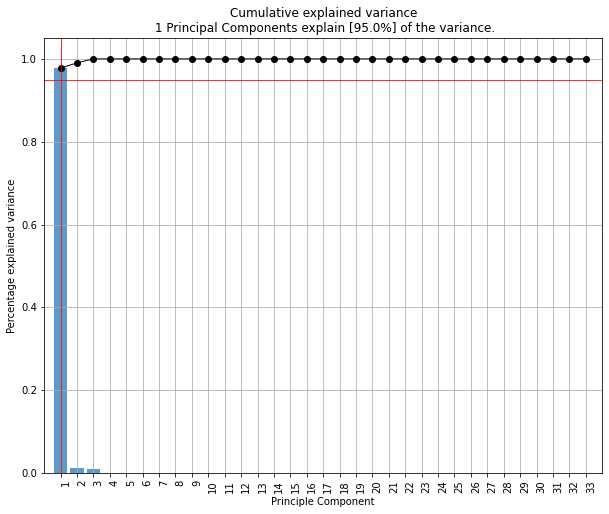

<Figure size 432x288 with 0 Axes>

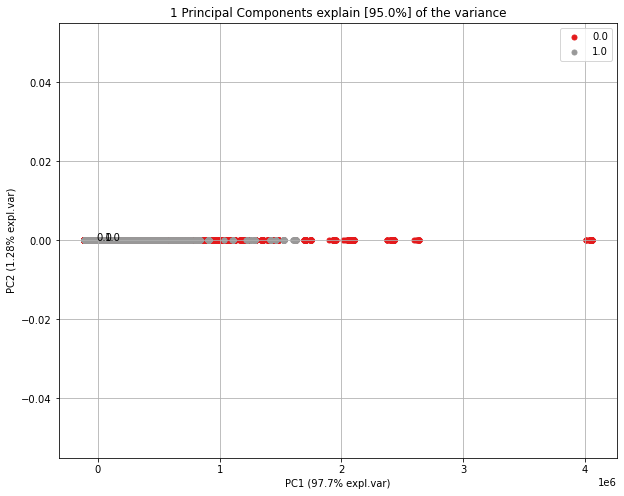

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pca import pca

x_new = x.drop("SPACEGROUP", axis=1)  # incompatible with scaler

model = pca(n_components=0.95)

results = model.fit_transform(x_new)

print(results['topfeat'])

fig, ax = model.plot()

fig, ax = model.scatter(y=y)
plt.show()

However, these results look incredibly **skewed**, especially for a complex anaylsis process like EP. Unsurprisingly, the top features all have one thing in common: their **scale**. Total (unique) observations, dataset id and shelxc n data all represent a number of measurements, which, in EP, can be of many order of magnitudes. This contrasts with the other metrics, some of which are within the -1 to 1 range.

This being the case, **data normalisation** is necessary. We could normalise the data using sklearn's StandardScaler, but the **cpa** can do it automatically.

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [33] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [17] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[17]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
      PC                    feature   loading  type
0    PC1                RPIM_DIFF_I  0.290689  best
1    PC2                     DIFF_I  0.369474  best
2    PC3               COMPLETENESS -0.311679  best
3    PC4     ANOMALOUS_MULTIPLICITY  0.368443  best
4    PC5         TOTAL_OBSERVATIONS  0.336109  best
5    PC6               SHELXC_RANOM  0.563857  best
6    PC7          SHELXC_RESOLUTION  0.484522  best
7    PC8                 WAVELENGTH

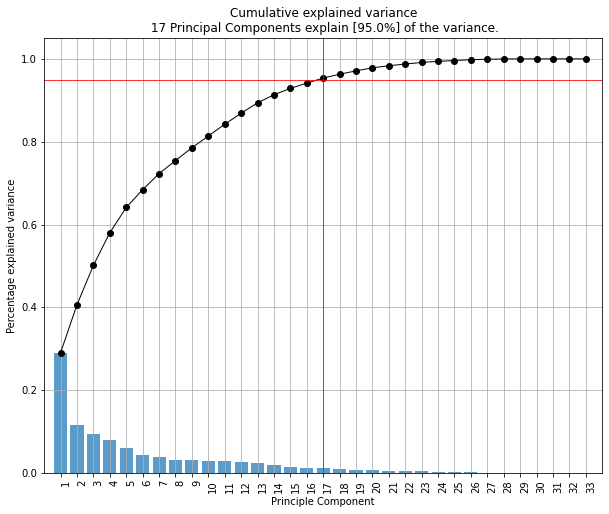

<Figure size 432x288 with 0 Axes>

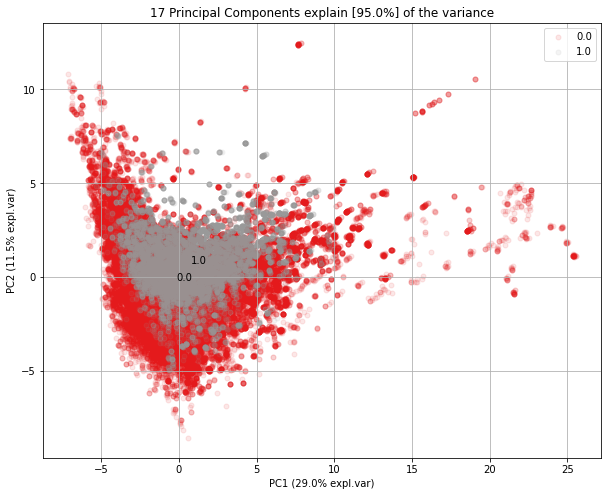

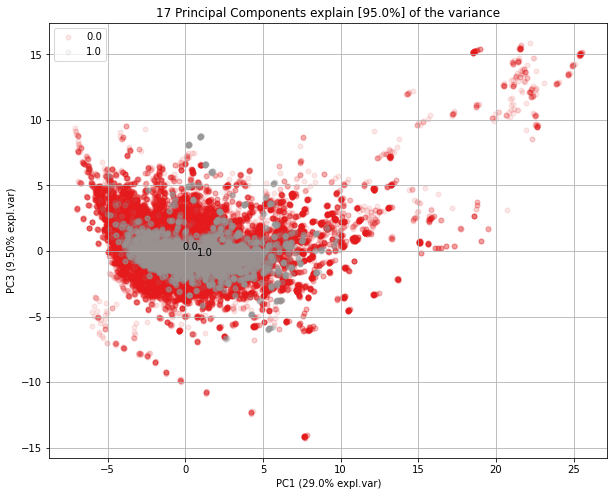

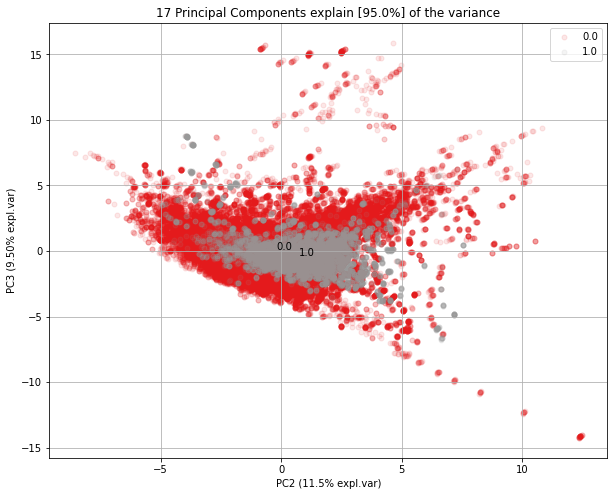

In [14]:
model = pca(n_components=0.95, normalize=True)
x_new = x.drop("SPACEGROUP", axis=1)
results = model.fit_transform(x_new)

print(results['topfeat'], sep="\n")

model.plot()

fig1, ax1 = model.scatter(y=y, PC=[0, 1], alpha_transparency=0.1)
fig2, ax2 = model.scatter(y=y, PC=[0, 2], alpha_transparency=0.1)
fig3, ax3 = model.scatter(y=y, PC=[1, 2], alpha_transparency=0.1)
axs = [ax1, ax2, ax3]

These results vary wildly from the previous ones, indicating how scaling was indeed a significant issue. The Scree plot is significantly more spread out, and shows that **95% of the variance is explained by 17 PCs**. This reduces the features down to around half, but there are still many left, as expected.

From the topfeat table, the top 5 features are **(RPIM) DIFF I**, **completeness**, **anomalous multiplicity** and **total observations**. The first relates to how well the various intensity "maps" combine into a single one, while the rest relate to the amount of interaction/intensity of the structure/signal. Interestingly, **DIFF F** is among the lowest PCs.

Suprisingly, the **low resolution limit** appears higher in the table than the **high resolution limit**, which is one of the last (**shelxc resolution** is higher than both of these). Anomalous features (such as **anomalous correlation** which is mainly in PC17)  are lower than expected from previous analysis.

Regarding the plots, a **cluster/separation** can be observed. This indicates that there is something which hints at a success/failure difference, even if not very clear. The points also seem to be very overlapped, so to check this, they are plotted separately.

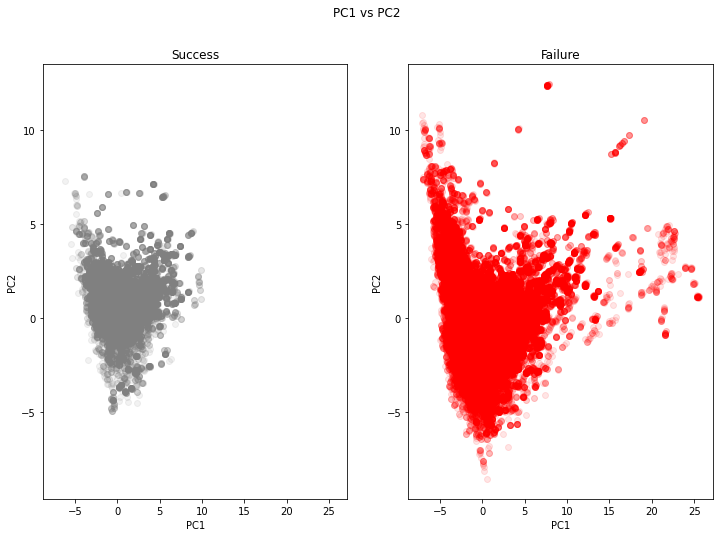

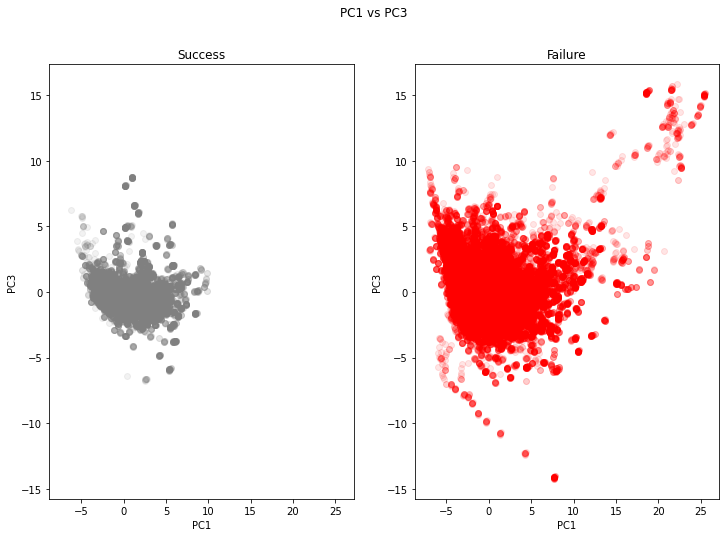

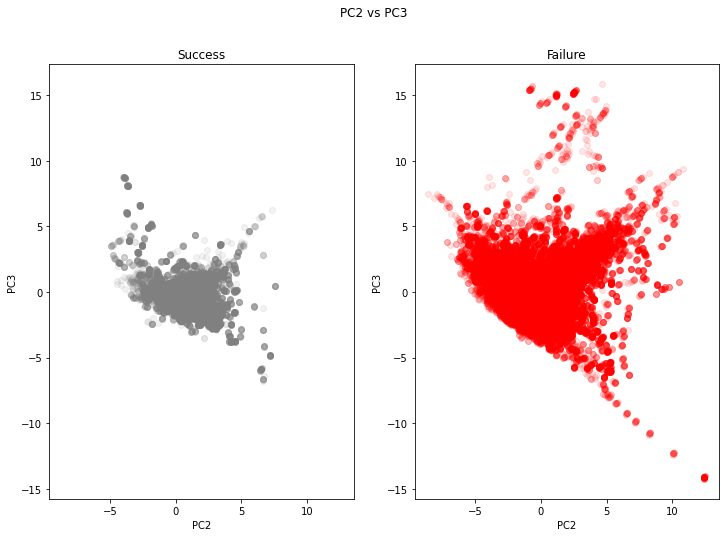

In [21]:
from itertools import combinations

success = y == 1
fail = y == 0

pc = results["PC"].loc[:, :"PC3"]
pc_success = pc[success]
pc_fail = pc[fail]

for i, (h, v) in enumerate(combinations(pc, 2)):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle(f"{h} vs {v}")
    
    for j, (data, title, c) in enumerate(zip([pc_success, pc_fail], ["Success", "Failure"], ["grey", "red"])):

        ax[j].scatter(data.loc[:, h], data.loc[:, v], c=c, alpha=.1)

        ax[j].set_xlabel(h)
        ax[j].set_ylabel(v)
        ax[j].set_title(title)

        ax[j].set_xlim(*axs[i].get_xlim())
        ax[j].set_ylim(*axs[i].get_ylim())

plt.show()

As can be seen from this series of plots, there is **significant overlap**, and the success/failure clusters can not be independently located/separated. As such, **a single (or even pair) of PC cannot fully designate a sweep's outcome**, as would be expected from the low individual PC variance. A certain PC range could be a requirement or good indicator for success, but not a certainty.

## A scaling check

Linear scaling doesn't usually interfere with correlation, we repeat the sorted correlation table just to check. We also repeat the previous analysis with a slight modification to the relative difference formula (this one sees the difference between success/failure relative to their mean).

In [5]:
x_new = x_new = x.drop("SPACEGROUP", axis=1)  # incompatible with scaler
x_new = pd.DataFrame(StandardScaler().fit_transform(x_new),
                     columns=x_new.columns, index=x_new.index)
x_new["SPACEGROUP"] = x["SPACEGROUP"]  # re-insert space group


# correlation
corr_sorted = abs(x.corrwith(y)).sort_values(ascending=False)
print(corr_sorted)


union = pd.concat([x.iloc[:, 1:], y], axis=1)

grp_both = union.groupby("IS_SUCCESS").agg(["mean", "median"])
rel_diff_both = abs((grp_both.iloc[0, :] - grp_both.iloc[1, :]) / np.mean(grp_both, axis=0))
rel_diff_both = rel_diff_both.sort_values(ascending=False)
print(rel_diff_both * 100)

HIGH_RES_LIMIT               0.388109
SHELXC_RESOLUTION            0.219051
DIFF_F                       0.180352
SHELXC_CFOM                  0.173497
SHELXC_MULTIPLICITY          0.165726
SHELXC_I_SIGMA               0.165083
I_SIGMA                      0.154476
TOTAL_UNIQUE_OBSERVATIONS    0.143695
ANOMALOUS_CORRELATION        0.143211
RMERGE_I                     0.137550
SHELXC_N_DATA                0.130983
TOTAL_OBSERVATIONS           0.130078
RMEAS_I                      0.129897
RMERGE_DIFF_I                0.100591
RMEAS_DIFF_I                 0.099898
RPIM_I                       0.097748
SHELXC_COMPLETENESS          0.095788
ANOMALOUS_COMPLETENESS       0.093413
RPIM_DIFF_I                  0.093313
DIFF_I                       0.090879
COMPLETENESS                 0.086270
SHELXC_SIGNAL                0.052102
CC_HALF                      0.045610
SHELXC_RANOM                 0.045047
SHELXC_RPIM                  0.045039
NUMBER_SITES                 0.033344
WAVELENGTH  

The correlation table indeed did not change, and an analysis of such can be read on  the previous notebook. The relative difference table did slightly change, but the previous analysis still stands.

# See if points overlap or are separated & do LDA